In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((478, 12, 1), (478,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 23s 311ms/step - loss: 0.1550 - root_mean_squared_error: 0.3937 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2153
Epoch 2/50
48/48 [==============================] - 10s 215ms/step - loss: 0.1013 - root_mean_squared_error: 0.3184 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1991
Epoch 3/50
48/48 [==============================] - 10s 207ms/step - loss: 0.0729 - root_mean_squared_error: 0.2701 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1948
Epoch 4/50
48/48 [==============================] - 1s 19ms/step - loss: 0.0708 - root_mean_squared_error: 0.2662 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 5/50
48/48 [==============================] - 1s 21ms/step - loss: 0.0678 - root_mean_squared_error: 0.2604 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 6/50
48/48 [==============================] - 10s 210ms/step - loss: 0.0644 - root_mean_squared_error: 0.2539 - val_loss: 0.0335 - va

48/48 [==============================] - 1s 29ms/step - loss: 0.0160 - root_mean_squared_error: 0.1267 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 34/50
48/48 [==============================] - 1s 24ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 35/50
48/48 [==============================] - 1s 22ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 36/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 37/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 38/50
48/48 [==============================] - 1s 19ms/step - loss: 0.0150 - root_mean_squared_error: 0.1225 - val_loss: 0.0146 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.5526190559069315 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

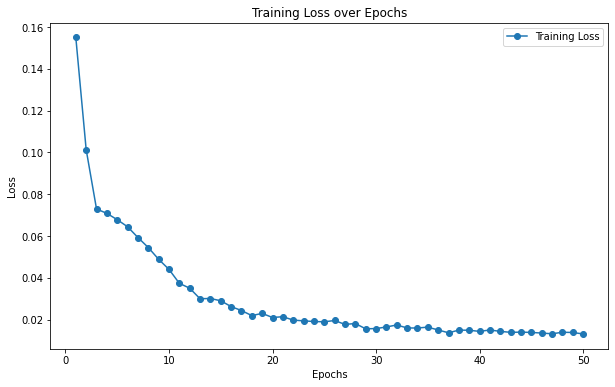

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

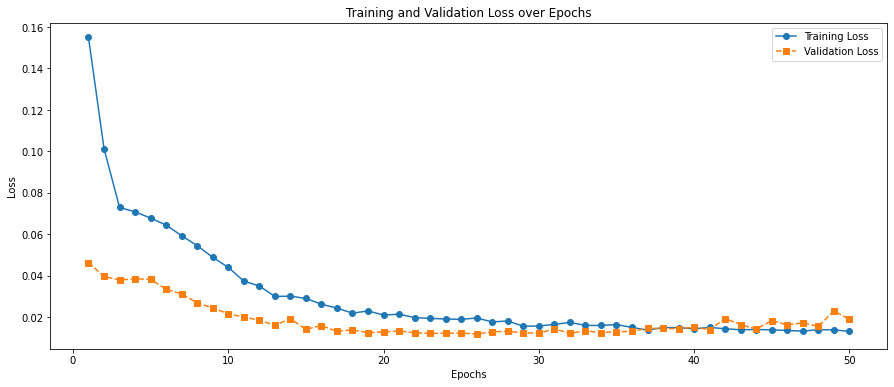

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.12844904270690125
MAE : 0.09015691348362313


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,-46715.183594,1707.377
1,-38883.226562,11293.282
2,28332.353516,49957.406
3,125789.476562,151973.751
4,223692.250000,466524.938
5,288926.718750,708542.184
6,290129.093750,652598.000
7,202732.937500,414216.785
8,89342.382812,236263.303
9,29039.677734,43422.368


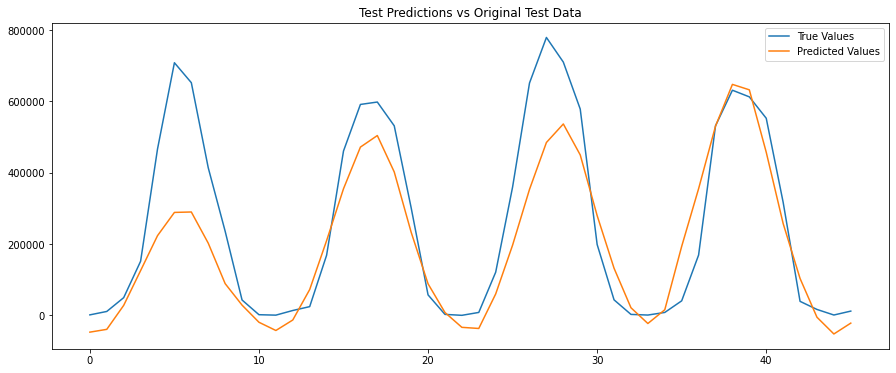

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

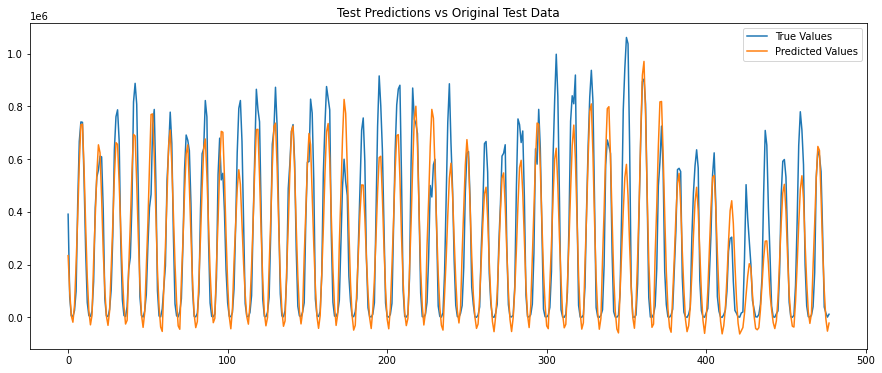

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()